This notebook has the details for the sentiment analysis

Installing all the required modules


In [ ]:
#!pip install -U textblob

In [ ]:
#!pip install wordcloud

In [1]:
# Import all the required modules
import pandas as pd
import numpy as np
import regex as re
import string
import nltk
import pickle
import sys
import json # I have used this to read json files
from collections import Counter 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from textblob import TextBlob
import seaborn as sns; sns.set(font_scale = 1.2)
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline
import pickle

import pandas as pd
import numpy as np

from gensim import matutils, models
import scipy.sparse

from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TreebankWordTokenizer


# Exploratory Data Analysis 

Source of data 

The below data source has been sourced from Kaggle :https://www.kaggle.com/littleotter/united-states-presidential-speeches. It has the presidential speeches until September 9th, 2019

The dataset was scraped from https://millercenter.org/the-presidency/presidential-speeches

At this stage, when I started my analysis I wanted to answer the below questions and these questions were my inspiration :
* How have political parties changed over the course of American History?
* What subjects or topics have different eras focused on with respect to parties or individual presidents?
* How do presidential speeches tones change throughout history with respect to events such as war, civil rights, ect.?

As I continue my analysis- I will add/modify or drop my questions and add my reasoning on the way.

#### Read the data source 

In [4]:
potus_speech = pd.read_csv('presidential_speeches.csv')

Let us take a look on the structure of the dataframe

In [5]:
potus_speech.columns

Index(['Date', 'President', 'Party', 'Speech Title', 'Summary', 'Transcript',
       'URL'],
      dtype='object')

So this has the following fields 

* Date of Speech
* Name of President 
* Party of President 
* Title of Speech
* Summary 
* Speech Transcript

### Analysis - Total number of speeches and the date ranges 

In [6]:
len(potus_speech) #

992

In [7]:
potus_speech['President'].describe()

count                   992
unique                   44
top       Lyndon B. Johnson
freq                     71
Name: President, dtype: object

In [8]:
potus_speech['Date'].min()

'1789-04-30'

In [9]:
potus_speech['Date'].max()

'2019-09-25'

Quick data look tells me that I am looking at **992 speeches** which range from 1789-04-30 to 2019-09-25 . This might have null values, let me remove them and continue my EDA

### Data Cleaning 


I can drop the URL column in the end as I dont plan on using it for any analysis

In [10]:
potus_speech.drop(columns = 'URL', inplace = True)

In [11]:
### Let us check for any null values 
potus_speech.isna().value_counts()

Date   President  Party  Speech Title  Summary  Transcript
False  False      False  False         False    False         686
                                       True     False         305
                                       False    True            1
dtype: int64

The Summary field has 305 Null values and Transcript has 1 Null value. So I will completely drop the Summary field and remove the transcript single null row 

In [12]:
potus_speech.drop(columns = 'Summary', inplace = True)

In [13]:
potus_speech.dropna(subset = ['Transcript'], inplace = True)

In [14]:
len(potus_speech)

991

For futher processing, I will pick up the transcripts 

In [15]:
transcripts = potus_speech['Transcript']

In [16]:
# Save them to a csv file 
transcripts.to_csv("data/transcripts.csv")

Analysis - I want to see the distribution of the presidential speeches across presidents

In [17]:
potus_speech_pres = pd.DataFrame()

In [18]:
potus_speech_pres['Count'] = potus_speech.groupby(['President']).President.count()

In [19]:
potus_speech_pres = potus_speech_pres.reset_index(drop = False)

In [20]:
potus_speech_pres.head()

,President,Count
0,Abraham Lincoln,15
1,Andrew Jackson,26
2,Andrew Johnson,31
3,Barack Obama,50
4,Benjamin Harrison,23


In [21]:
#fig,ax = plt.subplots()
#sns.set_color_codes("pastel")
#sns.barplot(x="Count" , y="President",data=potus_speech_pres, palette='pastel')

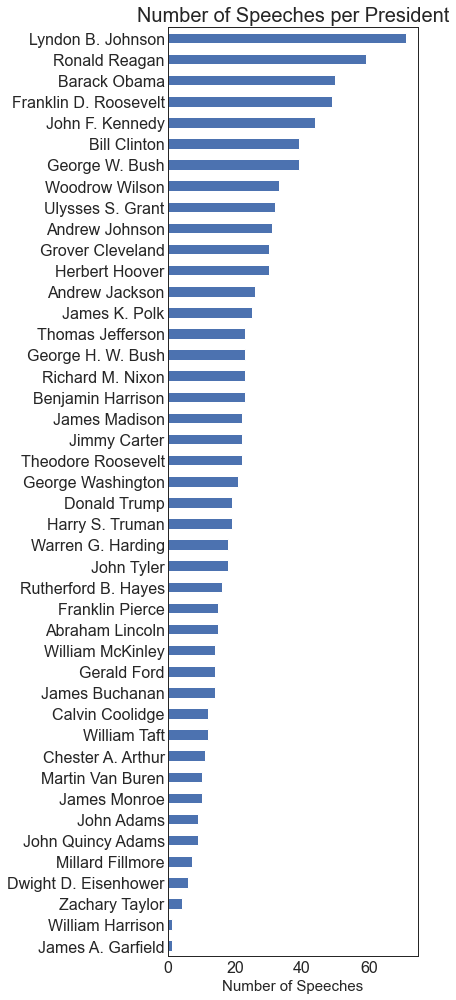

In [22]:
plt.figure(figsize=(6, 14))
potus_speech.President.value_counts(ascending=True).plot(kind = 'barh', )
plt.xlabel('Number of Speeches', fontsize = 15)
plt.title('Number of Speeches per President', fontsize = 20)
plt.tight_layout()
plt.savefig('No._Pres_Speeches.png');

Top three speeches :
* Lyndon B Johnson
* Ronald Reagen
* Barack Obama 

# Sentiment/Tone Analysis 

In [23]:
def clean_text_rd1(text):
    text = text.lower() #Convert the text to lowercase 
    text = re.sub('\[.*?\]', '', text) # Remove punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation),'', text)
    text = re.sub('\w*\d\w*', '', text) # remove words with numbers
    return text

In [24]:
clean_basic = lambda x: clean_text_rd1(x) # Define the function which I will apply later

In [25]:
# Apply baic cleaning to transcripts file 
transcripts_clean_rd1 = pd.DataFrame(potus_speech.Transcript.apply(clean_basic))

I will define a function which will clean the stop words 

In [26]:
def clean_text_rd2(text,tokenizer):
    stop_words = set(stopwords.words('english'))
    cleaned_text = []
    for words in text :
        cleaned_words = []
        for word in tokenizer.tokenize(words):
            if word not in stop_words:
                cleaned_words.append(word)
        cleaned_text.append(' '.join(cleaned_words))
    return pd.DataFrame(cleaned_text,columns = ['Transcript'])

In [27]:
transcripts_clean_rd2 = clean_text_rd2(transcripts_clean_rd1.Transcript,TreebankWordTokenizer())

In [28]:
#transcripts_clean_rd2

Let me pickle this clean version of the speech

In [29]:

# save cleaned transcripts as csv
with open('pickle/transcripts_clean_rd2.pickle', 'wb') as to_write:
    pickle.dump(transcripts_clean_rd2, to_write)

I will move on to the step of Count Vectorizer to get count for each term in the documents

In [30]:
cv = CountVectorizer(stop_words = 'english')
transcript_cv = cv.fit_transform(transcripts_clean_rd2.Transcript)
## let me crate a term matrix which is basically a dataframe of all the terms created by trascript_cv
transcript_cv_dtm = pd.DataFrame(transcript_cv.toarray(), columns = cv.get_feature_names())
#transcript_cv_dtm

Let me pickle the countvectorizer

In [31]:
with open('pickle/cv_stop.pickle','wb') as to_write:
    pickle.dump(cv,to_write)

Let me pickle the term matrix dataframe of the transcripts

In [32]:
with open('pickle/transcript_cv_dtm.pickle','wb') as to_write:
    pickle.dump(transcript_cv_dtm, to_write)

In [33]:
## Transform the matrix which will probably be needed for my analysis later 
transcript_dtm_cv_trans = transcript_cv_dtm.T

In [34]:
#transcript_dtm_cv_trans[8]

My next step will be to select top 20 words in each of the speech/transcript 

In [35]:
top_20_dict = {}
for transcript in transcript_dtm_cv_trans.columns:
    #print(transcript)
    top = transcript_dtm_cv_trans[transcript].sort_values(ascending = False).head(20)
    top_20_dict[transcript]= list(zip(top.index, top.values)) ## This will have the top 20 word for each speech
    #print(top)    

In [36]:
# Create lambda functions to find the polarity and subjectivity of each speech

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

potus_speech['polarity'] = potus_speech['Transcript'].apply(pol)
potus_speech['subjectivity'] = potus_speech['Transcript'].apply(sub)
#potus_speech.head()


In [37]:
#Create copy of dataframe with sentiments
potus_speech_sentiment = potus_speech.copy()

#Then save it as csv to be pulled into Tableau for visualization
potus_speech_sentiment.to_csv('data/potus_speech_sentiment.csv')

In [38]:
# Now let's create sentiment averages for the Presidents

potus_sentiment_only = potus_speech_sentiment.drop(columns=['Date','Speech Title','Transcript'])

potus_grouped_sentiment = potus_sentiment_only.groupby(
    ['President', 'Party'])[
    'polarity','subjectivity'].mean().reset_index()

#Then save it as csv to be pulled into Tableau for visualization
potus_grouped_sentiment.to_csv('data/potus_grouped_sentiment.csv')

# Sort by polarity and subjectivity to see who is strongest and lowest in these areas

potus_grouped_sentiment.sort_values(by=['subjectivity'], ascending=False)

<ipython-input-38-d1cafdb4ad3a>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  potus_grouped_sentiment = potus_sentiment_only.groupby(


,President,Party,polarity,subjectivity
8,Donald Trump,Republican,0.143820,0.502093
19,James A. Garfield,Republican,0.162603,0.498542
42,Woodrow Wilson,Democratic,0.125781,0.492843
39,William Harrison,Whig,0.151383,0.487550
17,Harry S. Truman,Democratic,0.161106,0.483067
26,John F. Kennedy,Democratic,0.135339,0.476264
9,Dwight D. Eisenhower,Republican,0.143460,0.475798
32,Richard M. Nixon,Republican,0.146029,0.470804
4,Benjamin Harrison,Republican,0.132958,0.469086
35,Theodore Roosevelt,Republican,0.107379,0.467252


In [39]:
potus_grouped_sentiment_party = potus_sentiment_only.groupby(['Party']).mean().reset_index()

In [40]:
potus_grouped_sentiment_party

,Party,polarity,subjectivity
0,Democratic,0.119715,0.451937
1,Democratic-Republican,0.135194,0.423806
2,Federalist,0.141827,0.463485
3,Republican,0.123453,0.453607
4,Unaffiliated,0.115913,0.444726
5,Whig,0.117557,0.438364


Not major difference in terms of party

No handles with labels found to put in legend.


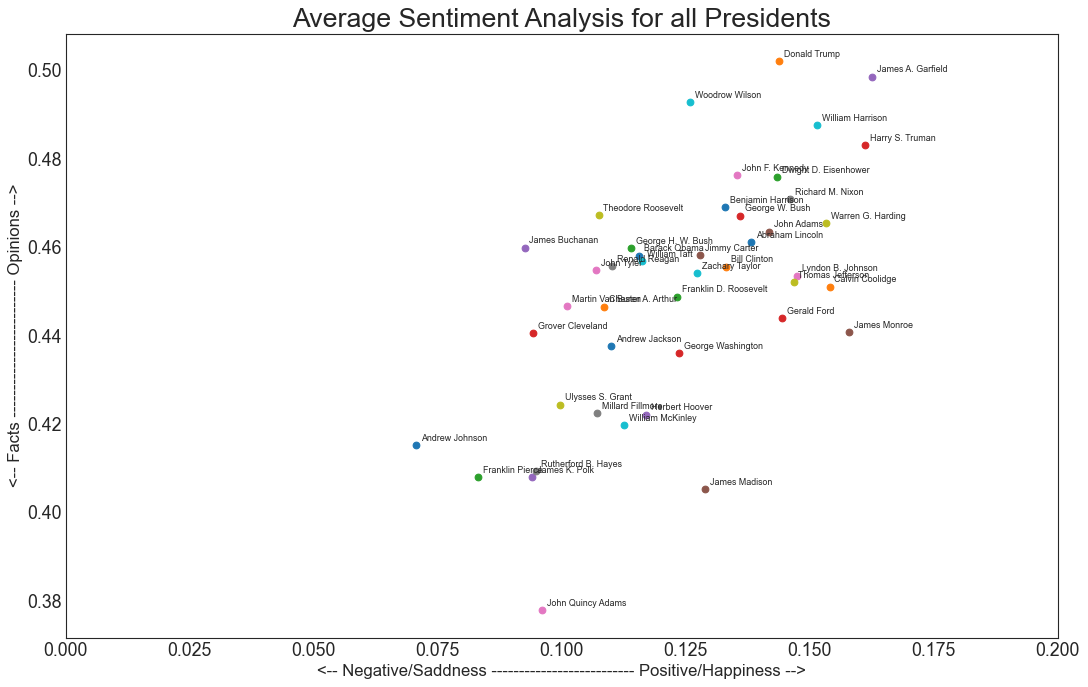

In [41]:
# Plot the results
import matplotlib.pyplot as plt

#plt.rcParams['figure.figsize'] = [20, 30]

# Draw Plot for Each Category
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

presidents = np.unique(potus_grouped_sentiment['President'])
colors = [plt.cm.tab10(i/float(len(presidents)-1)) for i in range(len(presidents))]


for index, president in enumerate(potus_grouped_sentiment.index):
    x = potus_grouped_sentiment.polarity.loc[president]
    y = potus_grouped_sentiment.subjectivity.loc[president]
    #plt.scatter(x, y, color=colors[index], label = str(presidents[index]))
    plt.scatter(x, y, color=colors[index])
    plt.text(x+.001, y+.001, potus_grouped_sentiment['President'][index], fontsize=8)
    plt.xlim(0, .20) 
    
plt.title('Average Sentiment Analysis for all Presidents', fontsize=24)
plt.xlabel('<-- Negative/Saddness -------------------------- Positive/Happiness -->', fontsize=15)
plt.ylabel('<-- Facts ------------------------- Opinions -->', fontsize=15)
plt.legend(fontsize=6) 
plt.show()

Observations from the above chart :(I want to keep these thoughts in the background)
* Donald Trump is highest on opinions
* John Quincy Adams is the highest on Facts but in between subjectivity
* Andrew Johnson is highest on negativity 
* Look at John Quincy Adams and John Adams are very different 


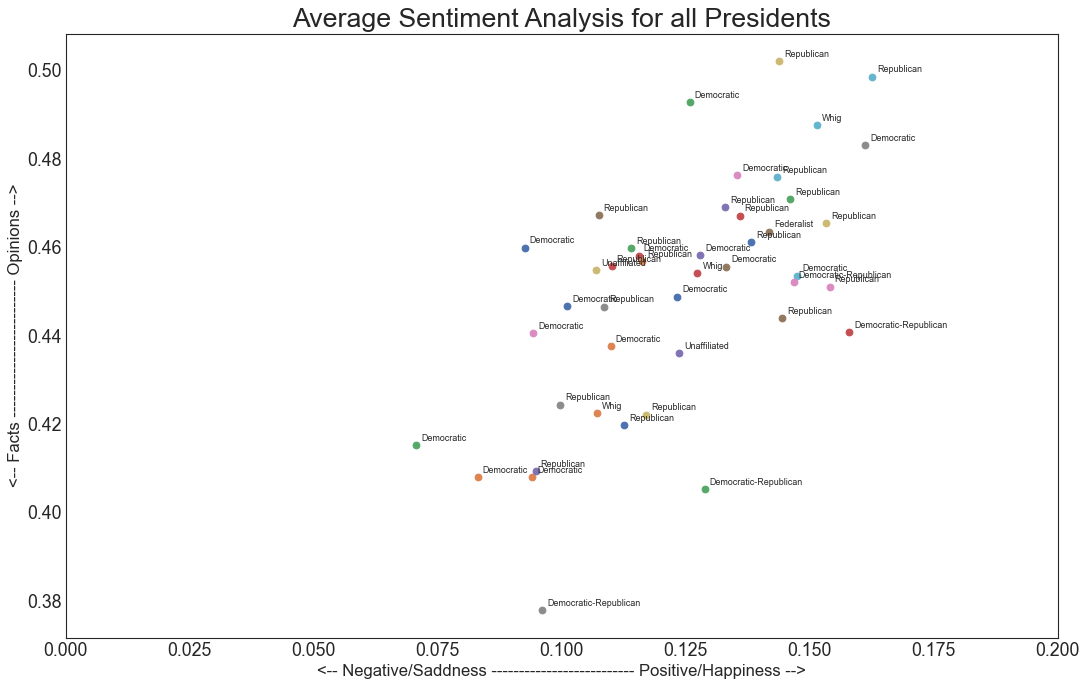

In [42]:
# Plot the results
import matplotlib.pyplot as plt

#plt.rcParams['figure.figsize'] = [20, 30]

# Draw Plot for Each Category
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

presidents = np.unique(potus_grouped_sentiment['Party'])
#colors = [plt.cm.tab10(i/float(len(presidents)-1)) for i in range(len(presidents))]


for index, president in enumerate(potus_grouped_sentiment.index):
    x = potus_grouped_sentiment.polarity.loc[president]
    y = potus_grouped_sentiment.subjectivity.loc[president]
    #plt.scatter(x, y, color=colors[index], label = str(presidents[index]))
    plt.scatter(x, y)
    plt.text(x+.001, y+.001, potus_grouped_sentiment['Party'][index], fontsize=8)
    plt.xlim(0, .20) 
    
plt.title('Average Sentiment Analysis for all Presidents', fontsize=24)
plt.xlabel('<-- Negative/Saddness -------------------------- Positive/Happiness -->', fontsize=15)
plt.ylabel('<-- Facts ------------------------- Opinions -->', fontsize=15)
#plt.legend(fontsize=6) 
plt.show()

## Sentiment/Tone Analysis - using IBM Tone Analyzer

In [48]:
#pip install --upgrade watson-developer-cloud

In [49]:
#The ToneAnalyzer class from WDC
from watson_developer_cloud import ToneAnalyzerV3

In [58]:
#-------------------------------------------------------------------------
#Instantiate TA Object with your Credentials
#-------------------------------------------------------------------------
tone_analyzer = ToneAnalyzerV3(
    username='anubhavpar@gmail.com',
    password='Sept232009.',
    version='2016-05-19',
    url = 'https://api.us-south.tone-analyzer.watson.cloud.ibm.com/instances/3a10e32f-ab3b-4916-a852-ad17df3396c6')
#-------------------------------------------------------------------------


/Users/anubhavpareek/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-58-f47e0ce58ca4>:4: DeprecationWarning: watson-developer-cloud moved to ibm-watson. To get updates, use the new package.
  tone_analyzer = ToneAnalyzerV3(


In [59]:
#------------------------------------------------------------------------
#Iterate Over All the Reviews and Append the Result:
#------------------------------------------------------------------------    
for index, review in enumerate(potus_speech.index):
    
    #Pass a single review to TA (one by one):
    json_output = tone_analyzer.tone(potus_speech.Transcript.loc[index], content_type='text/plain')    
    
    #Traverse the heirarchy of result
    for i in json_output['document_tone']['tone_categories']:
        for j in i['tones']:
            #Append the attributes to the data
            print (j)
            #small_data.set_value(index, j['tone_name'], j['score']) 
#------------------------------------------------------------------------

/Users/anubhavpareek/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


WatsonApiException: Error: Unauthorized: Access is denied due to invalid credentials , Code: 401 , X-dp-watson-tran-id: e32cc94f-a2c1-40c4-be64-95931a493d58 , X-global-transaction-id: e32cc94f-a2c1-40c4-be64-95931a493d58

## Word analysis 

In [60]:
from wordcloud import WordCloud

/Users/anubhavpareek/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
#!pip install wordcloud

In [61]:
addtl_stop_words = ["said","every","may","going","theyre","get","that","thats","make","ever","shall"]
wc = WordCloud(stopwords=addtl_stop_words,background_color="white", colormap="Dark2",
               max_font_size=100, random_state=42)

/Users/anubhavpareek/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


I will copy the above observations and further expand on them in this section

Observations from the above chart :(I want to keep these thoughts in the background)

* Donald Trump is highest on opinions
* John Quincy Adams is the highest on Facts but in between subjectivity
* Andrew Johnson is highest on negativity
* Look at John Quincy Adams and John Adams are very different

Question - Why do we think Donald Trump is highly opioniated 

Let me first what are the most spoken works by Donald Trump 

Donald Trump


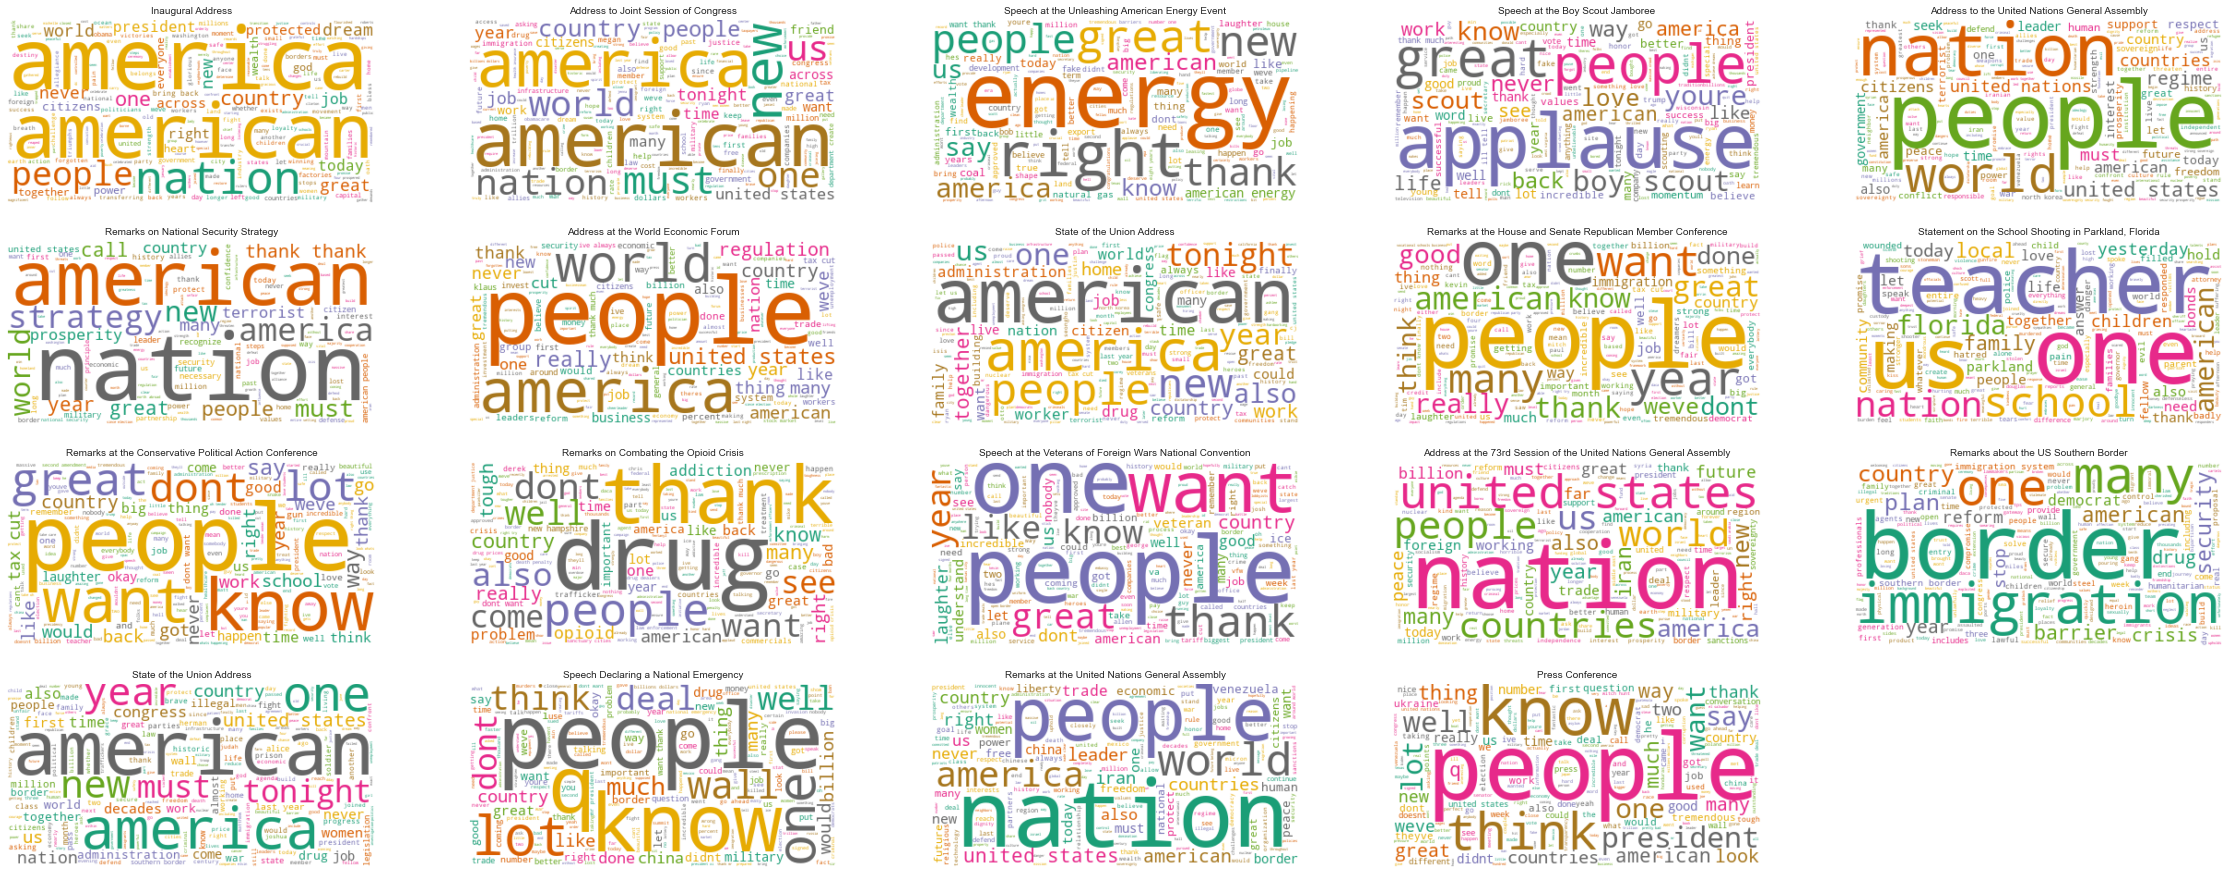

In [47]:
#Create wordclouds for all of Donald Trump's speeches

plt.rcParams['figure.figsize'] = [40, 40]

speech_dates = list(potus_speech['Speech Title'][-19:])

# Create plots just for single president
for index, date in enumerate(transcript_dtm_cv_trans.columns[-19:]):
    wc.generate(transcripts_clean_rd2.Transcript[date])
    
    plt.subplot(10, 5, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(speech_dates[index],size=10)

print('Donald Trump')
plt.show()

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["#FF0000", "#FF6347", "#DC143C", "#0000FF", "#0000CD", "#4169E1"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

# Use Republican Elephant & Democratic Donkey as masks
#p1_mask = np.array(Image.open('vector_images/clinton_silhouette.png'))
#p1_wc = WordCloud(background_color='white', colormap='Blues', mask=p1_mask, max_words=500)
#p1_wc.generate(p1_cloud)

p2_mask = np.array(Image.open('vector_images/trump_silhouette.png'))
p2_wc = WordCloud(background_color='white', colormap='Reds', mask=p2_mask, max_words=500)
p2_wc.generate(p2_cloud)

error_wc = WordCloud(background_color='white', colormap=cmap, max_words=500, width=1000, height=500)
error_wc.generate(error_cloud)

# Display word clouds
plt.figure(figsize=(20, 35))
plt.imshow(p1_wc)
plt.axis('off')
plt.show()

plt.figure(figsize=(20, 35))
plt.imshow(p2_wc)
plt.axis('off')
plt.show()

plt.figure(figsize=(20, 35))
plt.imshow(error_wc)
plt.axis('off')
plt.show()

### Topic Modeling 

First let me download the stop words 

In [2]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anubhavpareek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Now let me open the pickled filed

In [4]:
with open('pickle/transcript_cv_dtm.pickle','rb') as read_file:
    transcripts_dtm = pickle.load(read_file)

In [5]:
transcripts_dtm.head()

,aaa,aana,aaron,aarp,aback,abandon,abandoned,abandoning,abandonment,abandons,...,zollverein,zone,zones,zoning,zoological,zooming,zootsuiters,zte,zuckert,zuloaga
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let me try to start with LDA and Count Vectorizer

In [6]:
# Let me get the document-term matrix

In [8]:
transcripts_tdm = transcripts_dtm.T ## Taking a transpose
## This is basically words across 991 speeches

In [14]:
transcripts_tdm .shape

(37931, 991)

In [9]:
# I will have to convert this tdm to a gensim model
sparse_counts = scipy.sparse.csr_matrix(transcripts_tdm)

In [13]:
sparse_counts.shape

(37931, 991)

In [16]:
corpus = matutils.Sparse2Corpus(sparse_counts)

In [25]:
corpus

In [26]:
# Open previously pickled cv to create dictionary for gensim

with open('pickle/cv_stop.pickle','rb') as read_file:
    cv = pickle.load(read_file)

In [29]:
# create dictionary for gensim - Just a

id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [28]:
# LDA for num_topics = 2

lda1_2 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=20)
lda1_2.print_topics()

[(0,
  '0.012*"states" + 0.011*"government" + 0.008*"united" + 0.006*"congress" + 0.005*"public" + 0.005*"country" + 0.004*"shall" + 0.004*"people" + 0.004*"great" + 0.004*"state"'),
 (1,
  '0.010*"people" + 0.007*"world" + 0.005*"american" + 0.005*"new" + 0.005*"president" + 0.005*"america" + 0.005*"years" + 0.004*"time" + 0.004*"peace" + 0.004*"country"')]

Well the above two topics do not give me a lot of information. It seems to just focus on few words.Let me try to improve by adding more topics

In [30]:
lda1_3 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=20)
lda1_3.print_topics()

[(0,
  '0.011*"states" + 0.008*"government" + 0.007*"shall" + 0.007*"united" + 0.006*"state" + 0.006*"law" + 0.006*"people" + 0.005*"constitution" + 0.005*"congress" + 0.005*"power"'),
 (1,
  '0.010*"people" + 0.007*"world" + 0.006*"american" + 0.005*"new" + 0.005*"president" + 0.005*"america" + 0.005*"years" + 0.005*"time" + 0.004*"peace" + 0.004*"country"'),
 (2,
  '0.012*"states" + 0.011*"government" + 0.009*"united" + 0.007*"congress" + 0.005*"public" + 0.005*"country" + 0.005*"year" + 0.004*"great" + 0.004*"people" + 0.004*"time"')]

I really dont see a lot of interesting topics over here 

A blind shot - increasing the number of passes - definitely increasing to 50 passes does take a lot of time.

In [31]:
lda1_4 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=50)
lda1_4.print_topics()

[(0,
  '0.019*"president" + 0.014*"mr" + 0.012*"think" + 0.010*"people" + 0.006*"vietnam" + 0.006*"going" + 0.005*"time" + 0.005*"country" + 0.005*"united" + 0.004*"know"'),
 (1,
  '0.010*"people" + 0.008*"world" + 0.006*"new" + 0.006*"america" + 0.006*"american" + 0.005*"years" + 0.005*"peace" + 0.004*"nations" + 0.004*"time" + 0.004*"know"'),
 (2,
  '0.010*"government" + 0.006*"states" + 0.005*"law" + 0.005*"people" + 0.005*"congress" + 0.005*"great" + 0.004*"united" + 0.004*"country" + 0.004*"shall" + 0.004*"american"'),
 (3,
  '0.015*"states" + 0.011*"government" + 0.010*"united" + 0.007*"congress" + 0.005*"public" + 0.005*"country" + 0.005*"state" + 0.004*"shall" + 0.004*"people" + 0.004*"great"')]

Topic Modeling - Next modeling with Count Vectorizer and fine tuning parameters. 

In [34]:

# Get clean text
with open('pickle/transcripts_clean_rd2.pickle','rb') as read_file:
    transcripts_clean_rd2 = pickle.load(read_file)

In [37]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anubhavpareek/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [38]:
# Create a function to lemmatize the text

def lem_text(text, tokenizer, stemmer):
    cleaned_text = []
    for word in text:
        cleaned_words = []
        for word in tokenizer.tokenize(word):
            stem_word = stemmer.lemmatize(word)
            cleaned_words.append(stem_word)
        cleaned_text.append(' '.join(cleaned_words))
    return cleaned_text

In [39]:
# Lemmatize the cleaned transcripts

transcripts_clean_rd2_lem = lem_text(transcripts_clean_rd2.Transcript, TreebankWordTokenizer(), WordNetLemmatizer())

In [40]:
# Additional stop words that I want to remove to improve results of my topics
#  note words continuously were added to this list after seeing results from topics

add_stop_words = ['government','know','want','thats','mr',
                  'going','year','make','shall','let', 'subject',
                  'say', 'think','way','president','said'
                 ]

# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

Let me try to further refine my model by adding extra parameters :
* add new stop words 
* set max df -> This might change too commonly used words
* set min df -> This might remove words which are not used enough

In [41]:

# Create a new document-term matrix using new parameters

cv2 = CountVectorizer(stop_words=stop_words, min_df=.1, max_df=.8)
transcript_cv2 = cv2.fit_transform(transcripts_clean_rd2_lem)
transcript_cv_dtm_v2 = pd.DataFrame(transcript_cv2.toarray(), columns=cv2.get_feature_names())
transcript_cv_dtm_v2.head()

,abandon,ability,able,abroad,absence,absolute,absolutely,abundant,abuse,accept,...,worth,worthy,written,wrong,yes,yesterday,yield,york,young,youre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0


In [42]:
# Create the gensim corpus
corpus2 = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(transcript_cv_dtm_v2.T))

# Create the vocabulary dictionary
id2word2 = dict((v, k) for k, v in cv2.vocabulary_.items())

In [43]:
# LDA for num_topics = 2

lda2_2 = models.LdaModel(corpus=corpus2, id2word=id2word2, num_topics=2, passes=20)
lda2_2.print_topics()

[(0,
  '0.014*"american" + 0.012*"world" + 0.009*"america" + 0.008*"new" + 0.007*"peace" + 0.006*"war" + 0.006*"work" + 0.006*"right" + 0.005*"life" + 0.005*"today"'),
 (1,
  '0.010*"congress" + 0.009*"law" + 0.008*"power" + 0.007*"public" + 0.006*"duty" + 0.006*"act" + 0.005*"present" + 0.005*"war" + 0.005*"right" + 0.005*"citizen"')]

In [44]:
# LDA for num_topics = 3

lda2_3 = models.LdaModel(corpus=corpus2, id2word=id2word2, num_topics=3, passes=10)
lda2_3.print_topics()

[(0,
  '0.016*"world" + 0.012*"peace" + 0.012*"american" + 0.011*"war" + 0.007*"new" + 0.007*"men" + 0.006*"america" + 0.006*"force" + 0.006*"freedom" + 0.005*"life"'),
 (1,
  '0.010*"congress" + 0.010*"law" + 0.008*"public" + 0.007*"power" + 0.006*"act" + 0.006*"duty" + 0.005*"present" + 0.005*"citizen" + 0.005*"war" + 0.005*"right"'),
 (2,
  '0.014*"american" + 0.010*"america" + 0.009*"new" + 0.008*"work" + 0.007*"job" + 0.006*"tax" + 0.006*"right" + 0.006*"world" + 0.006*"congress" + 0.006*"need"')]

In [48]:
# LDA for num_topics = 4

lda2_4 = models.LdaModel(corpus=corpus2, id2word=id2word2, num_topics=4, passes=30)
lda2_4.print_topics()


[(0,
  '0.008*"work" + 0.007*"business" + 0.007*"congress" + 0.007*"american" + 0.007*"law" + 0.007*"national" + 0.006*"public" + 0.005*"men" + 0.005*"need" + 0.005*"increase"'),
 (1,
  '0.018*"world" + 0.014*"peace" + 0.012*"war" + 0.012*"american" + 0.008*"america" + 0.007*"freedom" + 0.007*"new" + 0.007*"men" + 0.007*"force" + 0.006*"life"'),
 (2,
  '0.016*"american" + 0.012*"america" + 0.010*"new" + 0.009*"job" + 0.008*"work" + 0.007*"tax" + 0.007*"right" + 0.007*"congress" + 0.006*"child" + 0.006*"dont"'),
 (3,
  '0.011*"congress" + 0.010*"law" + 0.008*"power" + 0.008*"public" + 0.007*"act" + 0.007*"duty" + 0.006*"citizen" + 0.005*"right" + 0.005*"constitution" + 0.005*"war"')]

In [47]:
# LDA for num_topics = 5

lda2_5 = models.LdaModel(corpus=corpus2, id2word=id2word2, num_topics=5, passes=20)
lda2_5.print_topics()


[(0,
  '0.015*"war" + 0.012*"peace" + 0.011*"men" + 0.010*"american" + 0.010*"world" + 0.008*"force" + 0.008*"vietnam" + 0.006*"military" + 0.005*"action" + 0.005*"south"'),
 (1,
  '0.013*"law" + 0.012*"congress" + 0.008*"act" + 0.008*"power" + 0.006*"duty" + 0.006*"public" + 0.006*"constitution" + 0.006*"department" + 0.005*"right" + 0.005*"territory"'),
 (2,
  '0.015*"american" + 0.014*"america" + 0.014*"world" + 0.010*"new" + 0.008*"right" + 0.007*"peace" + 0.007*"life" + 0.006*"freedom" + 0.006*"today" + 0.006*"work"'),
 (3,
  '0.012*"public" + 0.009*"power" + 0.008*"war" + 0.007*"congress" + 0.007*"duty" + 0.006*"present" + 0.006*"citizen" + 0.006*"bank" + 0.005*"treasury" + 0.005*"law"'),
 (4,
  '0.012*"american" + 0.010*"congress" + 0.010*"tax" + 0.010*"business" + 0.009*"work" + 0.008*"federal" + 0.007*"new" + 0.007*"need" + 0.007*"program" + 0.006*"national"')]

Takeaways from Attempt-2 LDA w/CV parameter models:
lda2_4: Seems the easiest to draw themes from. As I exten my results beyond 4 the topics start to diverge away

#### Topic Modelling - Attempt 3 

Try LDA with TFIDF 

In [49]:
#   using lemmatized words as done in Attempt #2

tf1 = TfidfVectorizer(stop_words=stop_words, min_df=.1, max_df=.8)
transcript_tf1 = tf1.fit_transform(transcripts_clean_rd2_lem)
transcript_cv_dtm_tf1 = pd.DataFrame(transcript_tf1.toarray(), columns=tf1.get_feature_names())
transcript_cv_dtm_tf1.head()

,abandon,ability,able,abroad,absence,absolute,absolutely,abundant,abuse,accept,...,worth,worthy,written,wrong,yes,yesterday,yield,york,young,youre
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,0.0,0.0,0.000000,0.051597,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.064118,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.0,0.0,0.030722,0.037091,0.0,0.0,0.0,0.113796,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.044726,0.0,0.0,0.0,0.0,0.039305,0.031751,0.0


In [50]:
# Create the gensim corpus
corpus3 = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(transcript_cv_dtm_tf1.T))

# Create the vocabulary dictionary
id2word3 = dict((v, k) for k, v in tf1.vocabulary_.items())

In [52]:

# LDA for num_topics = 2

tf1_2 = models.LdaModel(corpus=corpus3, id2word=id2word3, num_topics=2, passes=20)
tf1_2.print_topics()

[(0,
  '0.006*"law" + 0.005*"congress" + 0.005*"public" + 0.004*"power" + 0.004*"duty" + 0.004*"constitution" + 0.004*"treaty" + 0.004*"act" + 0.003*"citizen" + 0.003*"present"'),
 (1,
  '0.007*"american" + 0.007*"world" + 0.005*"america" + 0.004*"new" + 0.004*"peace" + 0.004*"war" + 0.004*"today" + 0.003*"life" + 0.003*"work" + 0.003*"freedom"')]

In [53]:
# LDA for num_topics = 4

tf1_4 = models.LdaModel(corpus=corpus3, id2word=id2word3, num_topics=4, passes=20)
tf1_4.print_topics()

[(0,
  '0.011*"world" + 0.010*"peace" + 0.009*"war" + 0.007*"vietnam" + 0.006*"soviet" + 0.006*"american" + 0.006*"force" + 0.005*"freedom" + 0.004*"america" + 0.004*"military"'),
 (1,
  '0.006*"law" + 0.005*"congress" + 0.005*"public" + 0.004*"power" + 0.004*"duty" + 0.004*"constitution" + 0.003*"act" + 0.003*"treaty" + 0.003*"war" + 0.003*"citizen"'),
 (2,
  '0.008*"american" + 0.006*"america" + 0.006*"world" + 0.005*"new" + 0.004*"work" + 0.004*"today" + 0.004*"job" + 0.004*"life" + 0.004*"help" + 0.003*"child"'),
 (3,
  '0.001*"law" + 0.001*"congress" + 0.001*"war" + 0.001*"treaty" + 0.001*"act" + 0.001*"constitution" + 0.001*"person" + 0.001*"power" + 0.001*"peace" + 0.001*"mexico"')]

In [54]:
# LDA for num_topics = 3

tf1_3 = models.LdaModel(corpus=corpus3, id2word=id2word3, num_topics=3, passes=20)
tf1_3.print_topics()

[(0,
  '0.001*"gold" + 0.001*"tariff" + 0.001*"business" + 0.001*"law" + 0.001*"industry" + 0.001*"cent" + 0.001*"bond" + 0.001*"rate" + 0.001*"increase" + 0.001*"congress"'),
 (1,
  '0.006*"law" + 0.005*"congress" + 0.005*"public" + 0.004*"power" + 0.004*"duty" + 0.004*"constitution" + 0.004*"act" + 0.004*"treaty" + 0.003*"citizen" + 0.003*"present"'),
 (2,
  '0.007*"american" + 0.007*"world" + 0.006*"america" + 0.004*"new" + 0.004*"peace" + 0.004*"war" + 0.004*"today" + 0.004*"life" + 0.003*"work" + 0.003*"freedom"')]

Dont see a lot of difference with respect by using TF-IDF instead of countvectorizer

#### Topic Modelling - Attempt 4

LDA with Count Vectorizer with tuned parameters + bigrams</br> Keeping parameters used in Attempt #2, but now also adding in option for bigrams

In [57]:
# Create a new document-term matrix, now adding bigram option

cv3 = CountVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=.1, max_df=.8)
transcript_cv3 = cv3.fit_transform(transcripts_clean_rd2_lem)
transcript_cv_dtm_v3 = pd.DataFrame(transcript_cv3.toarray(), columns=cv3.get_feature_names())
transcript_cv_dtm_v3.head()

,abandon,ability,able,abroad,absence,absolute,absolutely,abundant,abuse,accept,...,worthy,written,wrong,yes,yesterday,yield,york,young,young people,youre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0


In [59]:

# Create the gensim corpus
corpus4 = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(transcript_cv_dtm_v3.T))

# Create the vocabulary dictionary
id2word4 = dict((v, k) for k, v in cv3.vocabulary_.items())

In [60]:
# LDA for num_topics = 2

lda4_2 = models.LdaModel(corpus=corpus4, id2word=id2word4, num_topics=2, passes=20)
lda4_2.print_topics()

[(0,
  '0.013*"american" + 0.011*"world" + 0.009*"america" + 0.008*"new" + 0.006*"peace" + 0.006*"right" + 0.006*"work" + 0.006*"war" + 0.005*"life" + 0.005*"today"'),
 (1,
  '0.009*"congress" + 0.009*"law" + 0.007*"power" + 0.007*"public" + 0.005*"act" + 0.005*"duty" + 0.005*"war" + 0.005*"present" + 0.004*"right" + 0.004*"citizen"')]

In [61]:
# LDA for num_topics = 4

lda4_4 = models.LdaModel(corpus=corpus4, id2word=id2word4, num_topics=4, passes=20)
lda4_4.print_topics()

[(0,
  '0.009*"congress" + 0.008*"american" + 0.007*"work" + 0.007*"business" + 0.006*"federal" + 0.006*"national" + 0.005*"problem" + 0.005*"need" + 0.005*"program" + 0.005*"policy"'),
 (1,
  '0.016*"american" + 0.013*"america" + 0.010*"new" + 0.008*"job" + 0.008*"work" + 0.008*"right" + 0.007*"child" + 0.006*"family" + 0.006*"tax" + 0.006*"like"'),
 (2,
  '0.010*"law" + 0.010*"congress" + 0.008*"power" + 0.008*"public" + 0.006*"duty" + 0.006*"act" + 0.005*"present" + 0.005*"citizen" + 0.005*"right" + 0.005*"war"'),
 (3,
  '0.018*"world" + 0.014*"peace" + 0.013*"war" + 0.012*"american" + 0.008*"america" + 0.007*"force" + 0.007*"freedom" + 0.007*"men" + 0.007*"new" + 0.006*"life"')]

In [62]:
# LDA for num_topics = 6

lda4_6 = models.LdaModel(corpus=corpus4, id2word=id2word4, num_topics=6, passes=20)
lda4_6.print_topics()

[(0,
  '0.017*"american" + 0.013*"america" + 0.010*"new" + 0.009*"job" + 0.008*"work" + 0.007*"right" + 0.007*"child" + 0.007*"tax" + 0.006*"family" + 0.006*"dont"'),
 (1,
  '0.011*"law" + 0.010*"men" + 0.010*"right" + 0.009*"power" + 0.007*"man" + 0.007*"public" + 0.006*"principle" + 0.005*"constitution" + 0.005*"question" + 0.005*"free"'),
 (2,
  '0.019*"world" + 0.014*"peace" + 0.013*"war" + 0.012*"american" + 0.008*"america" + 0.008*"new" + 0.007*"force" + 0.007*"freedom" + 0.006*"today" + 0.006*"soviet"'),
 (3,
  '0.010*"congress" + 0.008*"american" + 0.007*"federal" + 0.007*"national" + 0.006*"work" + 0.006*"business" + 0.006*"problem" + 0.006*"increase" + 0.005*"policy" + 0.005*"economic"'),
 (4,
  '0.016*"law" + 0.013*"constitution" + 0.013*"act" + 0.012*"power" + 0.011*"congress" + 0.009*"duty" + 0.008*"authority" + 0.008*"person" + 0.008*"right" + 0.007*"officer"'),
 (5,
  '0.011*"congress" + 0.008*"public" + 0.007*"law" + 0.006*"power" + 0.006*"present" + 0.005*"duty" + 0.00

In [63]:
# LDA for num_topics = 7

lda4_7 = models.LdaModel(corpus=corpus4, id2word=id2word4, num_topics=7, passes=30)
lda4_7.print_topics()

[(0,
  '0.013*"question" + 0.008*"right" + 0.008*"constitution" + 0.008*"house" + 0.007*"general" + 0.007*"congress" + 0.007*"slavery" + 0.007*"law" + 0.007*"south" + 0.007*"election"'),
 (1,
  '0.013*"congress" + 0.010*"federal" + 0.010*"tax" + 0.009*"program" + 0.008*"economic" + 0.008*"american" + 0.008*"national" + 0.007*"problem" + 0.007*"business" + 0.007*"new"'),
 (2,
  '0.012*"congress" + 0.011*"power" + 0.009*"public" + 0.009*"law" + 0.008*"duty" + 0.008*"act" + 0.007*"citizen" + 0.007*"war" + 0.006*"constitution" + 0.006*"treaty"'),
 (3,
  '0.021*"world" + 0.017*"peace" + 0.016*"war" + 0.012*"american" + 0.009*"force" + 0.008*"new" + 0.008*"freedom" + 0.008*"america" + 0.007*"soviet" + 0.006*"today"'),
 (4,
  '0.017*"american" + 0.014*"america" + 0.010*"new" + 0.009*"work" + 0.009*"job" + 0.007*"child" + 0.007*"right" + 0.006*"family" + 0.006*"world" + 0.006*"like"'),
 (5,
  '0.010*"law" + 0.009*"congress" + 0.006*"department" + 0.006*"service" + 0.006*"work" + 0.006*"america

With number 7, I see that there are more different topics to work with . So I will stick with that 

### Topic Modeling - 5

LSA with Count Vector 

In [65]:
#Create a new document-term matrix using parameters that worked well for LDA as starting point

cv5 = CountVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=.1, max_df=.8)
transcript_cv5 = cv5.fit_transform(transcripts_clean_rd2_lem)
transcript_cv_dtm_v5 = pd.DataFrame(transcript_cv5.toarray(), columns=cv5.get_feature_names())
transcript_cv_dtm_v5.head()

,abandon,ability,able,abroad,absence,absolute,absolutely,abundant,abuse,accept,...,worthy,written,wrong,yes,yesterday,yield,york,young,young people,youre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0


In [66]:
# Run in LSA model for 2 topics and then print variance ratio

lsa1_2 = TruncatedSVD(2)
doc_topic_lsa1_2 = lsa1_2.fit_transform(transcript_cv_dtm_v5)
lsa1_2.explained_variance_ratio_

array([0.27011082, 0.09350062])

In [67]:
#create function to capture the words under each topic

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [68]:
#Examine first 10 words that fit under the topics

display_topics(lsa1_2, cv5.get_feature_names(), 10)


Topic  0
congress, law, american, power, public, new, war, right, act, work

Topic  1
american, world, america, job, new, tax, help, today, program, work


In [69]:
# Run in LSA model for 4 topics and then print variance ratio

lsa1_4 = TruncatedSVD(4)
doc_topic_lsa1_4 = lsa1_4.fit_transform(transcript_cv_dtm_v5)
lsa1_4.explained_variance_ratio_

array([0.27011082, 0.09350062, 0.046294  , 0.02932702])

In [70]:
# Examine first 10 words that fit under the topics

display_topics(lsa1_4, cv5.get_feature_names(), 10)


Topic  0
congress, law, american, power, public, new, war, right, act, work

Topic  1
american, world, america, job, new, tax, help, today, program, work

Topic  2
slavery, slave, constitution, compromise, territory, right, principle, union, free, man

Topic  3
law, work, business, slavery, court, slave, commission, man, service, men


Compared to the LSA output, the LDA was easier to interpret

Topic Modelling - Attempt #6

I will try to use NMF with Count Vectorizer

In [71]:
# Create a new document-term matrix using parameters that worked well for LDA as starting point

cv6 = CountVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=.1, max_df=.8)
transcript_cv6 = cv6.fit_transform(transcripts_clean_rd2_lem)
transcript_cv_dtm_v6 = pd.DataFrame(transcript_cv6.toarray(), columns=cv6.get_feature_names())
transcript_cv_dtm_v6.head()

,abandon,ability,able,abroad,absence,absolute,absolutely,abundant,abuse,accept,...,worthy,written,wrong,yes,yesterday,yield,york,young,young people,youre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0


In [72]:
nmf1_4 = NMF(8)
doc_topic_nmf1_4 = nmf1_4.fit_transform(transcript_cv6)

display_topics(nmf1_4, cv6.get_feature_names(), 10)

/Users/anubhavpareek/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
congress, treaty, war, public, mexico, citizen, report, present, secretary, new

Topic  1
american, america, new, work, child, congress, job, help, tonight, world

Topic  2
slavery, slave, compromise, territory, right, principle, free, law, man, new

Topic  3
world, peace, war, force, american, men, freedom, soviet, vietnam, america

Topic  4
power, constitution, law, public, congress, duty, act, bank, right, union

Topic  5
law, work, business, men, american, court, national, congress, public, department

Topic  6
examination, service, person, commission, place, rule, officer, appointment, test, general

Topic  7
dont, tax, thing, governor, question, weve, like, got, job, believe


LDA seems to be doing a better job of giving me distinct topics.

#### Mapping Topics to each speech

So I have decided to use the LDA model 4 with 7 topics as it gives me the most interpretable results. I will add the topics based on my judgement

In [75]:
# open master dataframe with speech information -- we'll be adding the topics to this

potus_speech_master = pd.read_csv('data/potus_speech_sentiment.csv')

In [76]:
#function to order topics for each document in decending weight value

def all_topics_ordered(all_topics_df): 
    '''
    Takes in a dataframe with topic tuples ([topic],[weight of topic])
    that are in individual columns for each row/document in the dataframe.  
    For every row/document the function creates a dataframe
    of all topic tuples for that row/document and sorts them by the 
    descending weight value of the topic, meaning the first
    tuple listed will have the greatest weight of association
    to the row/document.
    '''
    all_speech_topics = []
    for index, row in all_topics_df.iterrows(): 
        speech_topics = []
        for topic in row:
            if topic != None:
                speech_topics.append(topic)
        speech_topics.sort(key=lambda x:x[1], reverse=True)
        all_speech_topics.append(speech_topics)
    return pd.DataFrame(all_speech_topics)

In [77]:
# Create a function to place topics in the master dataframe for speeches

def first_topic(topics, master_df):
    '''
    Function takes in topic speech rankings from model and 
    places the first topic for each speech in the master
    dataframe for the speeches.
    ---
    Inputs: 
    -- topics = all speeches' topic rankings
    -- master_df = dataframe with all data on speeches
    
    Output:
    Master dataframe with two new columns:
    -- Topic: topic category
    -- Topic_Percent: percentage that speech fits in that category
    
    '''
    topic_cat = []
    topic_percent = []
    for x,y in topics[0]:
        topic_cat.append(x)
        topic_percent.append(y)

    master_df['Topic'] = topic_cat
    master_df['Topic_Percent'] = topic_percent
    
    return master_df

In [78]:
# create a listing of all of the topic rankings for each speech
corpus_transformed_lda4_7 = lda4_7[corpus4]

# make it into a dataframe
df_speech_topics_lda4_7 = pd.DataFrame(corpus_transformed_lda4_7)

In [79]:
# apply the function above to the dataframe created so that 
#  the topic with the greatest 'weight' will be listed first

ordered_topics_lda4_7 = all_topics_ordered(df_speech_topics_lda4_7)

In [80]:
#add first topic listing to master dataframe
potus_speech_master_lda4_7 = first_topic(ordered_topics_lda4_7, potus_speech_master)

In [81]:
# look at distribution of topics across speeches

potus_speech_master_lda4_7.Topic.value_counts()

2    268
3    195
4    173
6    131
5    105
1     65
0     54
Name: Topic, dtype: int64

In [89]:
# create new column replacing numerical topics with topic descriptions
#   these are topic descriptions selected based on words under each topic

topic_categories = potus_speech_master_lda4_7['Topic'].replace({
    0: 'Constitution', 
    1: 'Vietnam, War, Peace, Cold War',
    2: 'American Peace ',
    3: 'Business and Legislation',
    4: 'Job and Tax ',
    5: 'Public power',
    6: 'Law and Treaty'
})

In [95]:
topic_categories.head

<bound method NDFrame.head of 0               American Peace 
1                Law and Treaty
2               American Peace 
3               American Peace 
4               American Peace 
                 ...           
986                Job and Tax 
987                Job and Tax 
988                Job and Tax 
989    Business and Legislation
990                Job and Tax 
Name: Topic, Length: 991, dtype: object>

In [90]:
# create empty new row to input historical periods

potus_speech_master_lda4_7['Historical_Period'] = np.nan

In [91]:
# now add all historical periods for their appropriate date range

for index in range(0,len(potus_speech_master_lda4_7)):
    if index <= 27:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = '1789-1799: New Democratic Nation'
    elif index > 27 and index <= 209:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = '1800-1860: Settlement & Expansion'
    elif index > 210 and index <= 237:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = '1861-1865: American Civil War'
    elif index > 237 and index <= 337:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = '1865-1890: Reconstruction Era & Guilded Age'
    elif index > 337 and index <= 419:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = '1890-1913: Progressive Era'
    elif index > 419 and index <= 451:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = '1914-1918: World War I / Progressive Era'
    elif index > 451 and index <= 483:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = '1919-1928: Roaring Twenties / Progressive Era'
    elif index > 483 and index <= 512:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = '1929-1932: Great Depression'
    elif index > 512 and index <= 531:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = '1933-1938: Great Depression/New Deal'
    elif index > 531 and index <= 567:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = '1939-1945: World War II'
    elif index > 567 and index <= 584:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = '1946-1953: Cold War'
    elif index > 584 and index <= 652:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = '1954-1964: Cold War / Civil Rights Movement'
    elif index > 652 and index <= 699:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = '1965-1968: Cold & Vietnam Wars / Civil Rights Movement'
    elif index > 699 and index <= 716:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = '1969-1972: Cold & Vietnam Wars'
    elif index > 716 and index <= 736:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = '1973-1975:: Energy Crisis/Cold & Vietnam Wars'
    elif index > 736 and index <= 763:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = '1976-1980: Energy Crisis/Cold War'
    elif index > 763 and index <= 837:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = '1981-1991: Reagan Era / Cold War'
    elif index > 837 and index <= 881:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = '1992-2000: Neoconservative / Dot-Com Era'
    elif index > 881 and index <= 911:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = "2001-2006: 'War on Terror'"
    elif index > 911 and index <= 932:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = "2007-2009: Great Recession / 'War on Terror'"
    else:
        potus_speech_master_lda4_7.loc[index,'Historical_Period'] = "2010-2019: Ongoing 'War on Terror'"


In [92]:
# Let's now see how many speeches fall in each era

potus_speech_master_lda4_7['Historical_Period'].value_counts()

1800-1860: Settlement & Expansion                         182
1865-1890: Reconstruction Era & Guilded Age               100
1890-1913: Progressive Era                                 82
1981-1991: Reagan Era / Cold War                           74
1954-1964: Cold War / Civil Rights Movement                68
2010-2019: Ongoing 'War on Terror'                         59
1965-1968: Cold & Vietnam Wars / Civil Rights Movement     47
1992-2000: Neoconservative / Dot-Com Era                   44
1939-1945: World War II                                    36
1914-1918: World War I / Progressive Era                   32
1919-1928: Roaring Twenties / Progressive Era              32
2001-2006: 'War on Terror'                                 30
1929-1932: Great Depression                                29
1789-1799: New Democratic Nation                           28
1861-1865: American Civil War                              27
1976-1980: Energy Crisis/Cold War                          27
2007-200

In [93]:
## UPDATE THIS TO INCLUDE THE VERSION OF THE FINAL MODEL SELECTED

# Save the master database for all speeches with sentiment & topics as csv
#  to be pulled into Tableau for visualization

potus_speech_master_lda4_7.to_csv('data/potus_speech_master_topic_sentiment.csv')

In [98]:
potus_speech_master_lda4_7_data = potus_speech_master_lda4_7.copy()

In [99]:
potus_speech_master_lda4_7_data['Topic'] = potus_speech_master_lda4_7_data['Topic'].replace({
    0: 'Constitution', 
    1: 'Vietnam, War, Peace, Cold War',
    2: 'American Peace ',
    3: 'Business and Legislation',
    4: 'Job and Tax ',
    5: 'Public power',
    6: 'Law and Treaty'
})

In [102]:
potus_speech_master_lda4_7_data.head()

,Unnamed: 0,Date,President,Party,Speech Title,Transcript,polarity,subjectivity,Topic,Topic_Percent,Historical_Period
0,0,1789-04-30,George Washington,Unaffiliated,First Inaugural Address,Fellow Citizens of the Senate and the House of...,0.206467,0.428960,American Peace,0.530427,1789-1799: New Democratic Nation
1,1,1789-10-03,George Washington,Unaffiliated,Thanksgiving Proclamation,Whereas it is the duty of all Nations to ackno...,0.263889,0.470370,Law and Treaty,0.571408,1789-1799: New Democratic Nation
2,2,1790-01-08,George Washington,Unaffiliated,First Annual Message to Congress,Fellow Citizens of the Senate and House of Rep...,0.203224,0.443704,American Peace,0.917636,1789-1799: New Democratic Nation
3,3,1790-12-08,George Washington,Unaffiliated,Second Annual Message to Congress,Fellow citizens of the Senate and House of Rep...,0.173927,0.464649,American Peace,0.997864,1789-1799: New Democratic Nation
4,4,1790-12-29,George Washington,Unaffiliated,Talk to the Chiefs and Counselors of the Senec...,"I the President of the United States, by my ow...",0.097168,0.485468,American Peace,0.516937,1789-1799: New Democratic Nation


In [ ]:
potus_speech_master_lda4_7_data.to_csv('data/potus_speech_master_topic_sentiment.csv')